In [92]:
import sys
sys.path.append("./utils/")
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import tensorflow as tf
import numpy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from typing import Tuple
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from api_map import ping_api, check_available_endpoint_options

In [137]:
ping_api('users','headers')

{'users_headers': ['user_id',
  'created_time',
  'name',
  'username',
  'balance',
  'total_deposits',
  'is_bot',
  'profit_cached',
  'inserted_at',
  'updated_at']}

In [133]:
ping_api('ubbets','headers')

{'ubbets_headers': ['market_id',
  'bet_id',
  'amount',
  'created_time',
  'fills',
  'outcome',
  'user_id',
  'original_inserted_at']}

In [11]:
def get_ubbets_df():
    data = ping_api('ubbets','details')
    df = pd.DataFrame(data['ubbets'])
    headers = ping_api('ubbets','headers')['ubbets_headers']
    df.columns = headers
    return df

In [12]:
def cumulate_yes_bets(dataframe):
    # Filtering for 'YES' bets
    yes_bets = dataframe[dataframe['outcome'] == 'YES'].copy()  # Creating a copy to avoid warning
    
    # Convert timestamp to date
    yes_bets['Date'] = pd.to_datetime(yes_bets['created_time'], unit='ms').dt.date
    
    # Group by Date and sum the amounts
    cumulated_bets = yes_bets.groupby('Date')['amount'].sum().reset_index()
    
    # Sorting by Date
    cumulated_bets = cumulated_bets.sort_values(by='Date')
    
    return cumulated_bets

In [109]:
def show_daily_rolling_volativity_chart(df,window_size):
    # Convert timestamp to date
    df['Date'] = pd.to_datetime(df['created_time'], unit='ms').dt.date

    # Group by date and sum amounts
    daily_amounts = df.groupby('Date')['amount'].sum()

    # Compute daily returns
    daily_returns = daily_amounts.pct_change().dropna()

    # Compute rolling standard deviation (volatility) - using a window of 30 days as an example
    # Determine an appropriate window size
    volatility = daily_returns.rolling(window=window_size).std()

    # print(volatility)
    
    today = date.today()
    
    title = f"Daily Rolling Volatility, {window_size} Day Window, Unresolved Binary Markets as of {today}"

    # Plotting
    plt.figure(figsize=(14, 7))
    volatility.plot(color='blue')
    plt.title(title)
    plt.ylabel('Volatility')
    plt.xlabel('Date')
    plt.xlim(df['Date'].min(), df['Date'].max())  # This sets the x-axis limit to the range of our dataset
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [135]:
def show_timedecay_daily_rolling_volatility_chart(df, span):
    # Convert timestamp to date
    df['Date'] = pd.to_datetime(df['created_time'], unit='ms').dt.date

    # Group by date and sum amounts
    daily_amounts = df.groupby('Date')['amount'].sum()

    # Compute daily returns
    daily_returns = daily_amounts.pct_change().dropna()

    # Calculate the smoothing factor
    alpha = 2 / (span + 1)

    # Compute exponential weights for the entire series
    weights = [(1 - alpha) * (alpha**i) for i in range(len(daily_returns))]

    # Initialize empty list for volatility
    volatility_manual = []

    # Iterate over the daily returns to compute the weighted volatility
    for end in range(len(daily_returns)):
        weighted_returns = daily_returns.iloc[:end + 1] * weights[:end + 1][::-1]
        weighted_mean = sum(weighted_returns)
        weighted_variance = sum((daily_returns.iloc[:end + 1] - weighted_mean)**2 * weights[:end + 1][::-1])
        volatility_manual.append(weighted_variance**0.5)

    today = date.today()
    title = f"Daily Exponential Rolling Volatility (Manual), {span} Day Span, Unresolved Binary Markets as of {today}"

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(daily_returns.index, volatility_manual, color='blue')
    
    # Add vertical lines for every x-axis integer coordinate
    for x_coord in daily_returns.index:
        plt.axvline(x=x_coord, color='gray', linestyle='--', linewidth=0.5)
    
    plt.title(title)
    plt.ylabel('Volatility')
    plt.xlabel('Date')
    plt.xlim(df['Date'].min(), df['Date'].max())  # This sets the x-axis limit to the range of our dataset
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [110]:
# lambda function for usage below
def adjust_amount(row):
    if row['outcome'] == 'YES' and row['amount'] > 0:
        return row['amount']
    if row['outcome'] == 'NO' and row['amount'] > 0:
        return -row['amount']
    if row['outcome'] == 'YES' and row['amount'] < 0:
        return row['amount']
    if row['outcome'] == 'NO' and row['amount'] < 0:
        return -row['amount']

In [33]:
def arithmetic_adjustment_function(df: pd.DataFrame) -> pd.DataFrame:
    df['adjusted_amount'] = df.apply(adjust_amount, axis=1)
    return adjusted_df

In [35]:
def user_rows_market_columns(df: pd.DataFrame) -> pd.DataFrame:

    # Create the pivot table, with user_id as the index (rows) and market_id as the columns
    pivot_df = df.pivot_table(index='user_id', columns='market_id', values='adjusted_amount', aggfunc='sum', fill_value=0)
    
    return pivot_df

In [51]:
def tf_compute_cosine_similarity_array(df: pd.DataFrame) -> numpy.ndarray:

    # Convert pivot_df to a Tensor
    data_tensor = tf.convert_to_tensor(df.values, dtype=tf.float32)

    # Normalize each row (user's data)
    normalized_data_tensor = tf.nn.l2_normalize(data_tensor, axis=1)

    # Compute the cosine similarity matrix
    cosine_sim_tensor = tf.matmul(normalized_data_tensor, tf.transpose(normalized_data_tensor))

    # If you want to extract values back to a numpy array (if you want to use them outside of TF)
    cosine_sim_array = cosine_sim_tensor.numpy()
    
    return cosine_sim_array

In [55]:
def sk_compute_cosine_similarity_array(df: pd.DataFrame):
    # Convert the DataFrame to a sparse matrix for efficiency
    sparse_pivot = csr_matrix(df.values)

    # Compute the cosine similarity
    cosine_sim = cosine_similarity(sparse_pivot)
    
    return cosine_sim

In [99]:
def sklearn_pca_two_components(cosine_sim: numpy.ndarray) -> Tuple[pd.DataFrame, PCA]:

    # Number of components can be adjusted based on desired output
    pca = PCA(n_components=2)

    # Fit PCA on the cosine similarity matrix
    principal_components = pca.fit_transform(cosine_sim)

    # Convert the results into a DataFrame for easier handling and visualization
    pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
    
    return pca_df, pca, principal_components

In [98]:
def explained_variance(pca: pd.DataFrame):
    explained_variance = pca.explained_variance_ratio_

    # Print the variance explained by each component
    for i, exp_var in enumerate(explained_variance):
        print(f"Principal Component {i+1}: {exp_var*100:.2f}%")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
    plt.ylabel('Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Variance Explained by Each Component')
    plt.show()

In [103]:
def plot_kmeans_by_cluster(pca_df, clusters, principal_components):
    # Assuming you've chosen k (you can adjust this)
    k = clusters

    # Apply k-means clustering to the PCA results
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(principal_components)

    # Add the cluster assignments to the pca_df
    pca_df['Cluster'] = clusters
    
    today = date.today()
    
    title = f"PCA with K-means Clustering (k={k}), Unresolved Binary Markets as of {today}"


    # Plot the PCA results colored by their assigned k-means cluster
    plt.figure(figsize=(10, 8))
    for c in range(k):
        mask = pca_df['Cluster'] == c
        plt.scatter(pca_df[mask]['Principal Component 1'], pca_df[mask]['Principal Component 2'], label=f"Cluster {c}", s=50, alpha=0.7)

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label="Cluster Centers")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [198]:
def search_user_id(df, username):
    """
    Search for a user in the dataframe by username and return their user_id.

    Parameters:
    - df: The dataframe containing user information.
    - username: The username to search for.

    Returns:
    - user_id of the user if found, otherwise a message indicating the user was not found.
    """
    user = df[df['username'] == username]
    userbyname = df[df['name'] == username]
    if not user.empty:
        return user['user_id'].iloc[0]
    elif not userbyname.empty:
        return user['user_id'].iloc[0]    
    else:
        return "User not found."

In [139]:
def get_users_df():
    data = ping_api('users','details')
    df = pd.DataFrame(data['users'])
    headers = ping_api('users','headers')['users_headers']
    df.columns = headers
    return df

In [332]:
def get_username(users_df, user_id_to_search):
    user_subset = users_df[users_df['user_id'] == user_id_to_search]['username']
    
    if not user_subset.empty:  # Check if there's a matching user_id
        return user_subset.iloc[0]
    else:
        return 'no match'


In [191]:
def plot_kmeans_by_cluster_with_user_transparent(pca_df, ubbets_userrows_adjusted_df, clusters, principal_components, users_df, username):

    # Find the user_id
    user_id = search_user_id(users_df, username)
    print(f'username {username} found with user_id {user_id}')
    
    # Assuming you've chosen k (you can adjust this)
    k = clusters

    # Apply k-means clustering to the PCA results
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(principal_components)

    # Add the cluster assignments to the pca_df
    pca_df['Cluster'] = clusters
    
    today = date.today()
    title = f"PCA with K-means Clustering (k={k}), Unresolved Binary Markets as of {today}"

    # Plot the PCA results colored by their assigned k-means cluster
    plt.figure(figsize=(10, 8))
    for c in range(k):
        mask = pca_df['Cluster'] == c
        plt.scatter(pca_df[mask]['Principal Component 1'], pca_df[mask]['Principal Component 2'], label=f"Cluster {c}", s=50, alpha=0.7)

    # Plot cluster centers
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label="Cluster Centers")

    # Plot the point for the given user_id at the end using a large semi-opaque circle
    user_pca_coordinates = pca_df.loc[ubbets_userrows_adjusted_df.index == user_id]
    plt.scatter(user_pca_coordinates['Principal Component 1'], user_pca_coordinates['Principal Component 2'], c='grey', marker='o', s=1000, edgecolor='yellow', linewidths=1, alpha=0.5, zorder=5, label=f"User {username}")
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    print(user_pca_coordinates)

In [333]:
def report_users_by_cluster(pca_df, ubbets_userrows_adjusted_df, cluster_label, users_df):
    # Filter the pca_df by the given cluster_label
    cluster_users = pca_df[pca_df['Cluster'] == cluster_label]

    # find the columns for the given cluster
    ubbets_userrows_adjusted_df_userid_columns = cluster_users.index
    
    # extract user_ids based upon location in the original userrows dataframe, by column location, to list
    extracted_user_ids_list = ubbets_userrows_adjusted_df.iloc[ubbets_userrows_adjusted_df_userid_columns].index.tolist()
    
    usernamelist = []
    for user_id in extracted_user_ids_list:
        username = get_username(users_df, user_id)
        usernamelist.append(username)

    # Return the report
    return usernamelist

# The Main Program

In [17]:
# takes a long time
ubbets_df = get_ubbets_df()

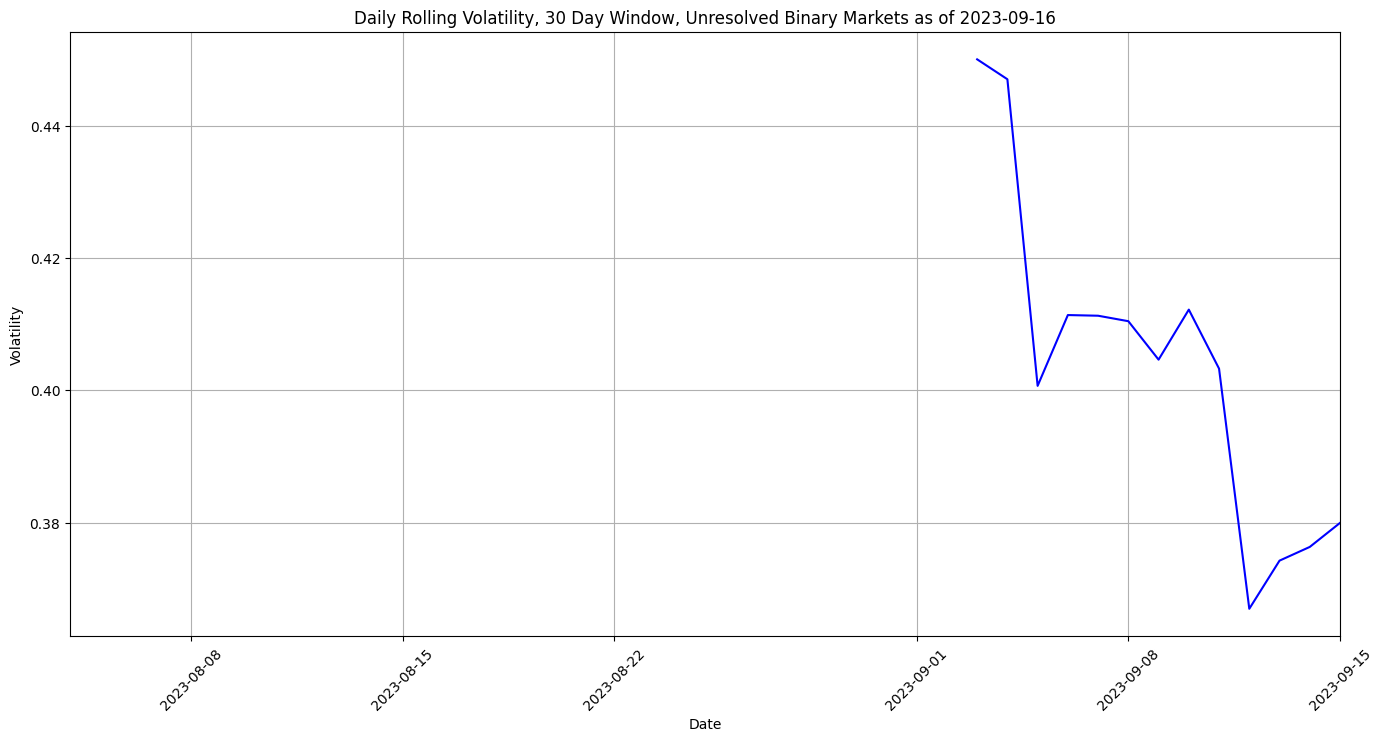

In [132]:
show_daily_rolling_volativity_chart(ubbets_df,30)

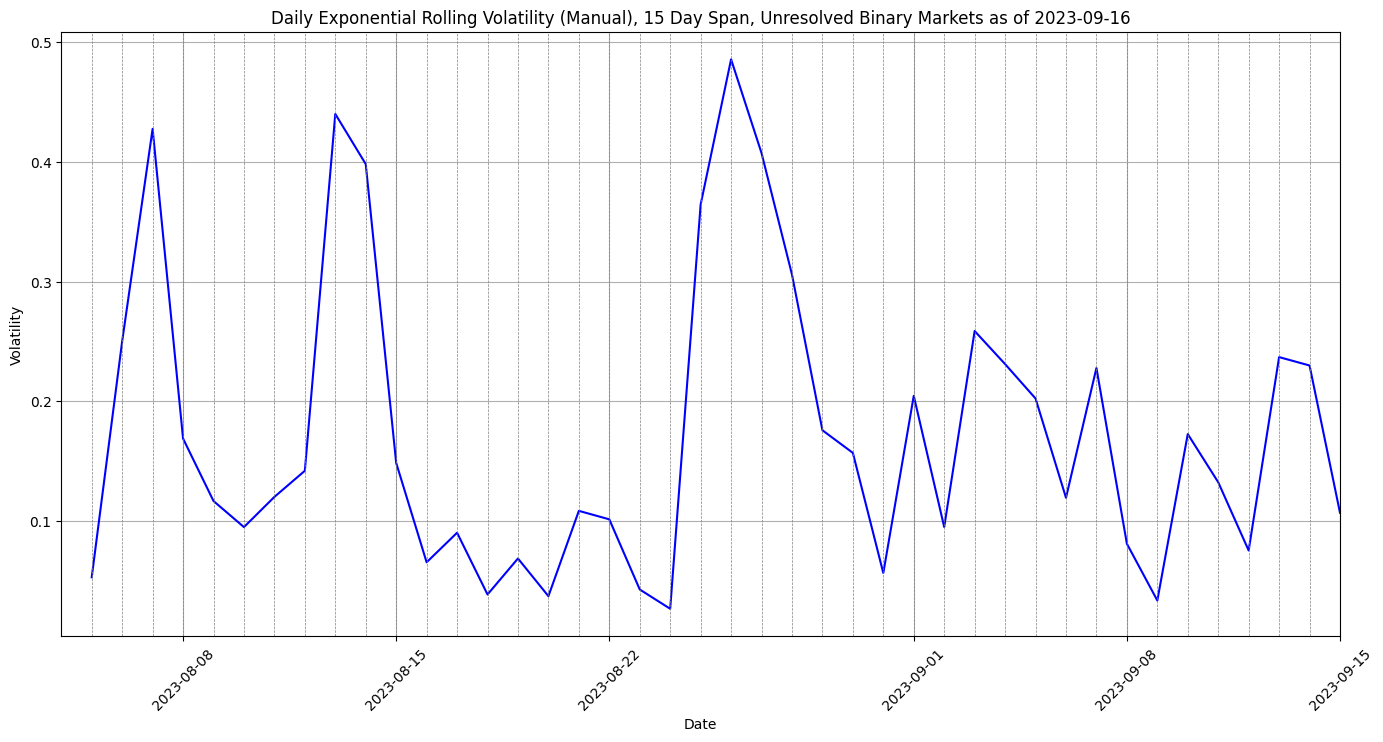

In [136]:
show_timedecay_daily_rolling_volatility_chart(ubbets_df,15)

In [37]:
ubbets_adjusted_df = arithmetic_adjustment_function(ubbets_df)

In [38]:
ubbets_userrows_adjusted_df = user_rows_market_columns(ubbets_adjusted_df)

In [53]:
tf_cosine_sim_array = tf_compute_cosine_similarity_array(ubbets_userrows_adjusted_df)

In [56]:
sk_cosine_sim_array = sk_compute_cosine_similarity_array(ubbets_userrows_adjusted_df)

In [100]:
ubbets_userrows_skpca_df, skpca, skprincomp = sklearn_pca_two_components(sk_cosine_sim_array)

Principal Component 1: 17.90%
Principal Component 2: 4.26%


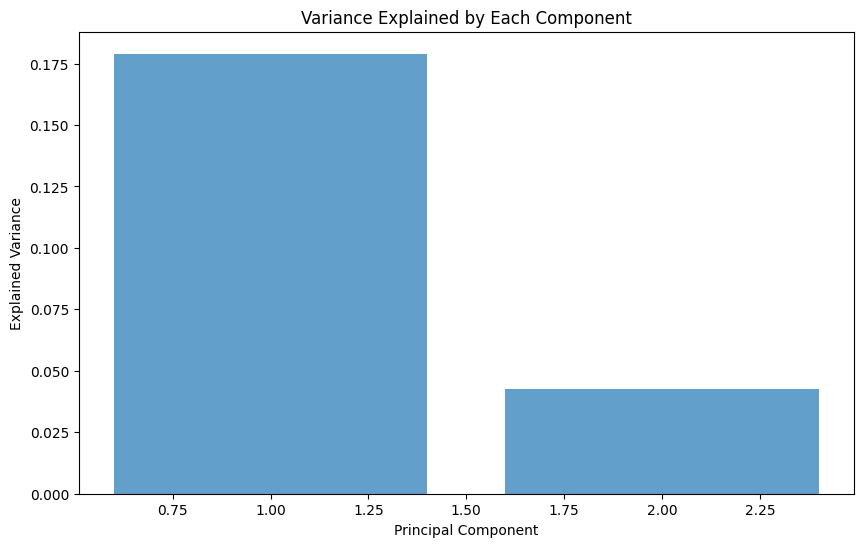

In [89]:
explained_variance(skpca)

/opt/conda/envs/tf_gpu_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


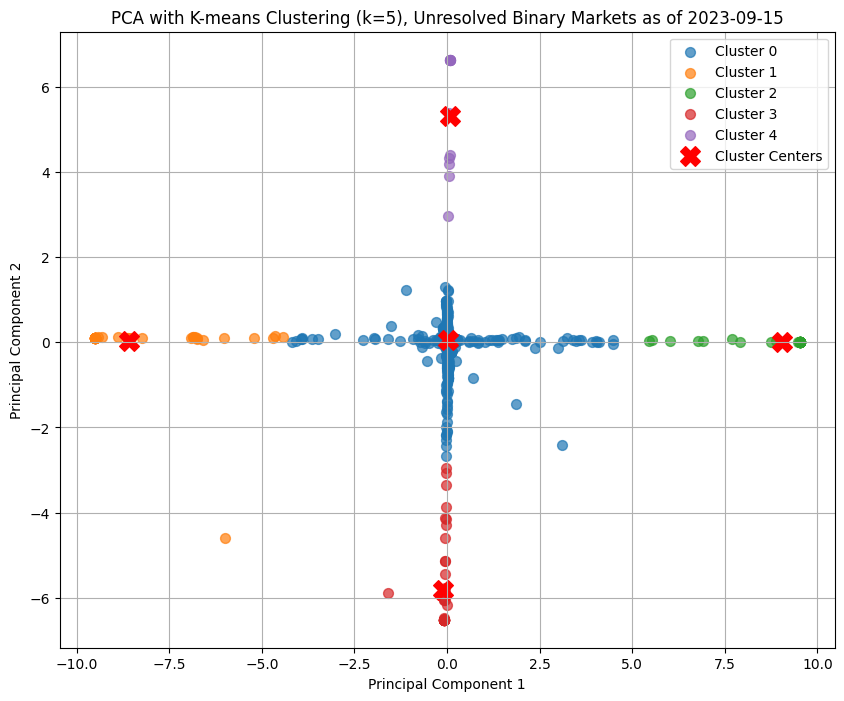

In [104]:
plot_kmeans_by_cluster(ubbets_userrows_skpca_df,5,skprincomp)

username JBohaska found with user_id User not found.


/opt/conda/envs/tf_gpu_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


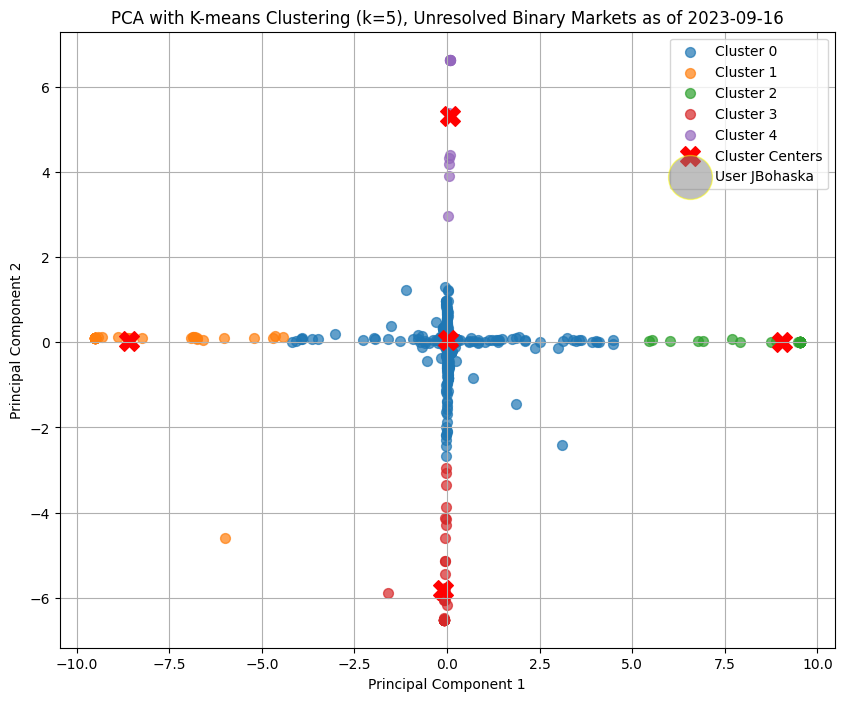

Empty DataFrame
Columns: [Principal Component 1, Principal Component 2, Cluster]
Index: []


In [265]:
plot_kmeans_by_cluster_with_user_transparent(ubbets_userrows_skpca_df, ubbets_userrows_adjusted_df, 5, skprincomp, users_df, 'JBohaska')

In [337]:
report = report_users_by_cluster(ubbets_userrows_skpca_df, ubbets_userrows_adjusted_df, 1, users_df)
report

['AdamSmithffc4',
 'no match',
 'BillB17',
 'JackFrey',
 'no match',
 'no match',
 'no match',
 'no match',
 'thewalkingzombie',
 'CharlieBaracks',
 'no match',
 'no match',
 'no match',
 'no match',
 'LuisLara',
 'BH_Sidlingu17BH',
 'no match',
 'no match',
 'no match',
 'no match',
 'no match',
 'ErikSolano',
 'no match',
 'no match',
 'EarlAdams',
 'no match',
 'ArtBlakey',
 'KurtSanders',
 'no match',
 'no match',
 'no match',
 'Aziz',
 'no match',
 'no match',
 'no match',
 'no match',
 'kelvinnganga',
 'no match',
 'no match',
 '7052',
 'no match',
 'no match',
 'no match',
 'AdelArezki',
 'no match',
 'no match',
 'AltonWells05cd',
 'no match',
 'no match',
 'MD8225',
 'temp',
 'SynDior',
 'no match',
 'no match']